We begin by loading our dependencies and the data which we chose to examine. The following displays the data for aapl as a sample:

In [17]:
using CSV
using DataFrames
using Statistics
using Plots
amzn = DataFrame(CSV.File("data/Amazon.csv"))
gold = DataFrame(CSV.File("data/Gold.csv"))
oil = DataFrame(CSV.File("data/Oil.csv"))
net = DataFrame(CSV.File("data/NFLX.csv"))
aapl = DataFrame(CSV.File("data/aapl.csv"))

,Date,Open,High,Low,Close,Adj Close,Volume
,String15,Float64,Float64,Float64,Float64,Float64,Int64
1,3/22/2017,34.9625,35.4,34.94,35.355,33.3808,103440800
2,3/23/2017,35.315,35.395,35.1525,35.23,33.2628,81385200
3,3/24/2017,35.375,35.435,35.0875,35.16,33.1967,89582400
4,3/27/2017,34.8475,35.305,34.655,35.22,33.2533,94300400
5,3/28/2017,35.2275,36.01,35.155,35.95,33.9426,133499200
6,3/29/2017,35.92,36.1225,35.7975,36.03,34.0181,116760000
7,3/30/2017,36.0475,36.125,35.875,35.9825,33.9732,84829200
8,3/31/2017,35.93,36.0675,35.7525,35.915,33.9095,78646800
9,4/3/2017,35.9275,36.03,35.7625,35.925,33.9189,79942800


From here we begin our examination of the ARMA model as a predictor of the next day's stock data.

# ARMA Model

From here we begin our examination of the ARIMA model as a predictor for the next day's data point.

The ARMA model functioned by looking back at previous days' predicted values as well as the errors of those predictions, following the function below:
yt = c + ϕ1 yt-1 + θ1 ϵt-1 ….+ϕt y0+θt ϵ0
-yt is the predicted value
-c is a chosen constant
-ϕ is the weight of the previous prediction
-θ is the weight of the error
-ϵ is the error of the prediction
The equation picks a function for the weights, such as 1/t, where t is the amount of iterations back that had been predicted

When generating a prediction for the current day which considers the predictions and errors of the n days preceding it, the time complexity is O(n) and the flop count is equal to 4n + 1. The space complexity of the algorithm is O(n) as well.

The code to apply this function was built recursively and functioned the following way:
1. The solver function which acts as ARMA is called and the array of values, and starting index, 0, are passed in
2. Next the function initializes the variable, prev, which will hold the previous prediction
3. Next it checks the if statement which acts as the base case, and if the array has a size which is greater than 1, it calls itself again passing in an array with the first value cut off, and back being incremented by one
4. This is repeated until the break case is hit, which means that y0 has been reached and it returns the remaining value in info, this is stored in prev
5. Then it breaks out of the if statement and returns the ARMA function solved at the current index, i.e. if it has been recurred 5 times and there were 6 data points, it would be at the 5th index, and since the time data was stored backwards it was at the second point chronologically, and the weight function is applied correctly with the weight being (1/t) or (1/5). It also adds the previous value so the values add up
6. Finally the value at the next time is returned, and the data is modeled. Afterwards, if a constant is needed it can be applied 

In [18]:
#First attempt
function solver1(info,back)
    prev = 0.0
    if(size(info)[1]!=1)
        prev = solver1(info[2:size(info)[1]],back+=1)
    else
        return info[1]
    end
    return (exp(-back)*info[1,1])+(exp(-back)*info[1,1])+prev
end


solver1 (generic function with 1 method)

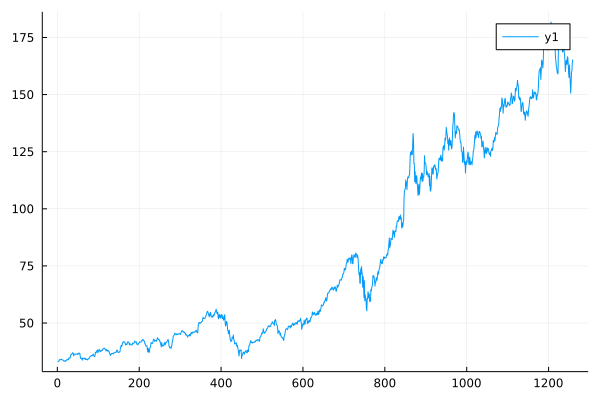

In [19]:
using Plots
plot([1:1259],aapl[:,6])

In [20]:
###SOLVE RECURSIVELY
#Call oslver which loops back through x days
#Second Attempt / Function used to find errors
errs = []
function solver2(info,back)
    #println(back)
    prev = 0.0
    if(size(info)[1]!=1)
        prev = solver2(info[1:size(info)[1]-1],back+=1)
    else
        return info[1]
    end
    return (exp(-back)*info[size(info)[1],1])+(exp(-back)*(abs(prev-info[size(info)[1]-1,1])))+prev
end

solver2 (generic function with 1 method)

In [21]:
#inal version
function fixedsolver(info,back)
    #println(back)
    prev = 0.0
    if(size(info)[1]!=1)
        prev = solver2(info[1:size(info)[1]-1],back+=1)
    else
        return info[1]
    end
    return (exp(-back)*info[size(info)[1],1])+((1/back)*(errs[back]))+prev
end

fixedsolver (generic function with 1 method)

# ARIMA Model

From here we begin our examination of the ARIMA model as a predictor for the next day's data point.

Whereas our usage of ARMA predicts the price of a given stock or commodity directly based on previous days' prices, ARIMA makes use of a different mechanism. ARIMA is an integrated model, meaning that its focus is on calculating the differences between consecutive days' prices rather than the prices themselves. From there, the resulting data set can be graphed in an integrated fashion when provided an initial condition, thereby yielding a predictive data set.

When generating a prediction for the current day which considers the predictions and errors of the n days preceding it, the time complexity is O(n) and the flop count is equal to 5n + 1. The space complexity of the algorithm is O(n) as well.

The following funtion implements the ARIMA model. The arguments are as follows:
- data, the dataset to be examined
- daysToCover, the number of days which should be examined by the model. If n days are covered, price change predictions will be generated for days 2 - n+1
- daysToLookBack, the number of preceding days which should be considered when predicting the change in price for a given day. This can be considered the "memory" of the model.
- weightFunction, the weighting function for the influence of preceding days' price changes and errors on the given day's prediction. In general, a strictly decreasing exponential function of x is most appropriate for this, as any increasing function will place unwarranted interest on old data. However, possible use cases could exist in which a linear or constant function may be more appropriate.
- c, a manual constant modifier for every predicted price change. While the utility of this will not be explored in our examination, it is present due to its presence in the model itself.

In [22]:
### Solves with ARIMA model

function ARIMASolve(data, daysToCover, daysToLookBack, weightFunction, c)
    dP = zeros(daysToCover)
    predictions = zeros(daysToCover + 1)
    residual = zeros(daysToCover)
    dP[1:daysToLookBack] = data[2:(daysToLookBack + 1)] - data[1:daysToLookBack]
    for i in (daysToLookBack + 1):daysToCover
        predictions[i] = c
        for j in daysToLookBack:-1:1
            predictions[i] = predictions[i] + weightFunction(j) * (dP[i - j] + residual[i - j])
        end
        residual[i] = (data[i + 1] - data[i]) - predictions[i]
        dP[i] = predictions[i] + residual[i]
    end
    predictions[daysToCover + 1] = c
    for j in daysToLookBack:-1:1
        predictions[daysToCover + 1] = predictions[daysToCover + 1] + weightFunction(j) * (dP[daysToCover + 1 - j] + residual[daysToCover + 1 - j])
    end
    return predictions
end

ARIMASolve (generic function with 1 method)

We begin by examining the utility of this model at a large scale. The following plot illustrates the true value of the aapl stock for the first 1000 days of data available alongside the value predicted by the ARIMA model. In this case, the ten preceding days' prices are considered when predicting the change for that day. A weighting function of 2/(e^x) is used to give weighting priority to the two days immediately preceding the day being examined. This results in a model which is highly reactive to sudden price changes and closely fits the true data. However, as is shown below, this also leads to a general overreaction in the case of sudden changes in price. The ramifications of this will be explored in more detail below.

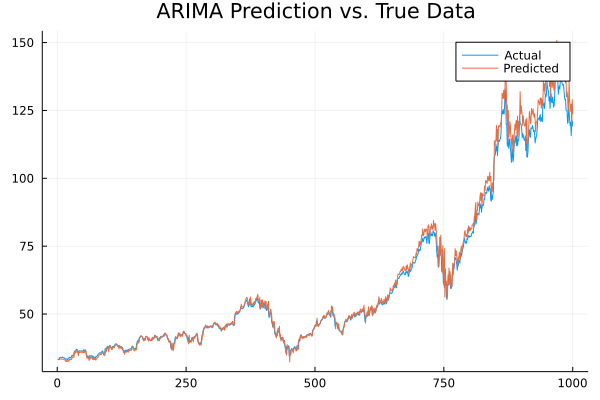

In [23]:
predicted = zeros(1000)
predicted[1] = aapl[1, 6]
dPs = ARIMASolve(aapl[1:1000, 6], 998, 10, x -> 2/(exp(x)), 0)
for i in 1:length(dPs)
    predicted[i + 1] = predicted[i] + dPs[i]
end
display(plot(1:1000, [aapl[1:1000, 6] predicted], title = "ARIMA Prediction vs. True Data", label = ["Actual" "Predicted"]))

The following graph makes use of the same data calculated above to demonstrate the residual between the true and predicted data. As stated previously, the model produced has a general tendancy to overreact to sudden changes in price. Due to the price of aapl generally trending positive, this results in generally positive residuals. The average of the residuals is also shown below to further emphasize this trend.

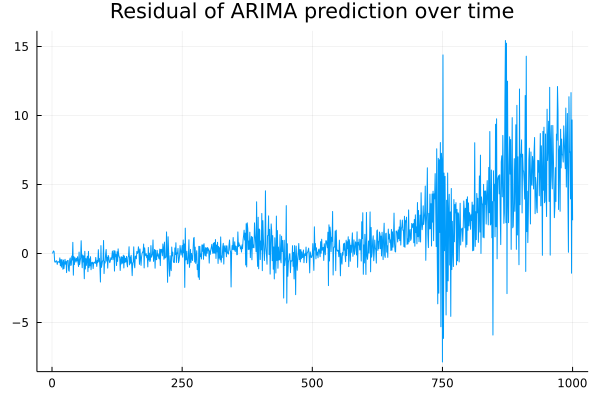

1.3594221871706442

In [24]:
residual = predicted - aapl[1:1000, 6]
display(plot(1:1000, residual, title = "Residual of ARIMA prediction over time", legend = false))
display(Statistics.mean(residual))

The following graph represents these residuals once more in the form of a scatter plot. The residuals of the predicted changes in price are plotted relative to the true changes in price. This demonstrates a strong clustering around (0,0) accompanied by generally decreased predictability as the true change in price increases in magnitude. This indicates a higher degree of accuracy for less volatile price data.

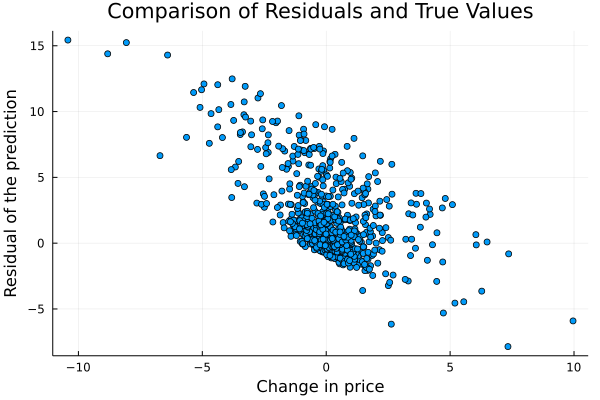

In [25]:
plot(aapl[2:1000, 6] - aapl[1:999, 6], predicted[2:1000] - aapl[2:1000, 6], seriestype = :scatter, xlabel = "Change in price", ylabel = "Residual of the prediction", legend = false, title = "Comparison of Residuals and True Values")

While the above plot does show the generalized "accuracy" of the model, it does not consider what results in major flaws in the prediction. In order to do so, consider the following. The graph below considers the magnitude of the actual price change one day prior to the day being predicted. This is due to the fact that when calculating the prediction for the next day, the model gives primary consideration to the change in price which preceded it. This results in a generally linear trend between the two, although outliers are still present.

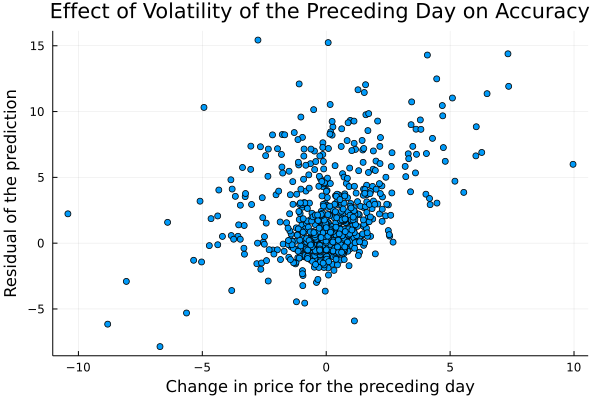

In [26]:
plot(aapl[2:999, 6] - aapl[1:998, 6], predicted[3:1000] - aapl[3:1000, 6], seriestype = :scatter, legend = false, xlabel = "Change in price for the preceding day", ylabel = "Residual of the prediction", title = "Effect of Volatility of the Preceding Day on Accuracy")

A final consideration of note is the general trend-wise correlation of the prediction and the true values.The following is simply a scatter plot representation of the predicted prices relative to the actual prices. Generally, this makes clear that while a certain degree of instability does exist in the prediction, it does still demonstrate merit at a large scale.

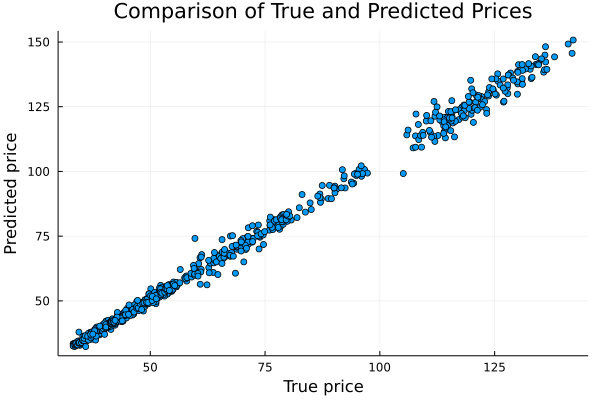

In [27]:
plot(aapl[1:1000, 6], predicted[1:1000], seriestype = :scatter, legend = false, xlabel = "True price", ylabel = "Predicted price", title = "Comparison of True and Predicted Prices")

The following graphs will examine the same trends as above with the alternative data sets.

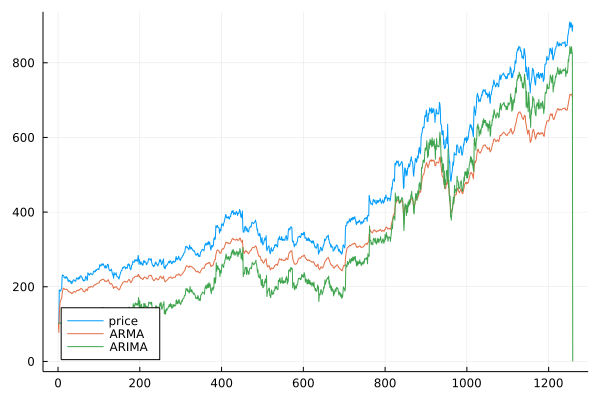

In [28]:
r = r","
c = r"-"
amz=[]
for i in amzn[:,6]
    i = replace(i,r => "")
    i = replace(i,c => "0")
    push!(amz,parse(Float64,i))
end
amz = reverse(amz)
predicted = zeros(1259)
predicted[1] = amz[1]
dPs = ARIMASolve(amz, 1256, 10, x -> 2/(exp(x)), 0)
for i in 1:length(dPs)
    predicted[i + 1] = predicted[i] + dPs[i]
end
errs = []
#farthest back is largest number, i.e. 0th index is end of range-1
for i in 1:1259
   pred = solver2(amz[1:i],0)
   pushfirst!(errs,pred-1000)
end
plotArma = []
for i in 1:1259
   pred = fixedsolver(amz[1:i],0)
   pushfirst!(plotArma,pred)
end
plotArma = reverse(plotArma)
plot(1:1259,amz[1:1259],label="price")
plot!(1:1259,plotArma,label="ARMA")
plot!(1:1259,predicted,label="ARIMA",legend=:bottomleft)

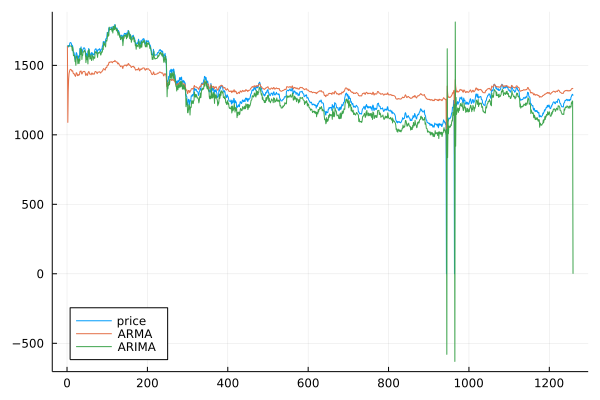

In [29]:
r = r","
c = r"-"
amz=[]
for i in gold[:,6]
    i = replace(i,r => "")
    i = replace(i,c => "0")
    push!(amz,parse(Float64,i))
end
amz = reverse(amz)
predicted = zeros(1259)
predicted[1] = amz[1]
dPs = ARIMASolve(amz, 1256, 10, x -> 2/(exp(x)), 0)
for i in 1:length(dPs)
    predicted[i + 1] = predicted[i] + dPs[i]
end
errs = []
#farthest back is largest number, i.e. 0th index is end of range-1
for i in 1:1259
   pred = solver2(amz[1:i],0)
   pushfirst!(errs,pred-3900)
end
plotArma = []
for i in 1:1259
   pred = fixedsolver(amz[1:i],0)
   pushfirst!(plotArma,pred)
end
plotArma = reverse(plotArma)
plot(1:1259,amz[1:1259],label="price")
plot!(1:1259,plotArma,label="ARMA")
plot!(1:1259,predicted,label="ARIMA",legend=:bottomleft)

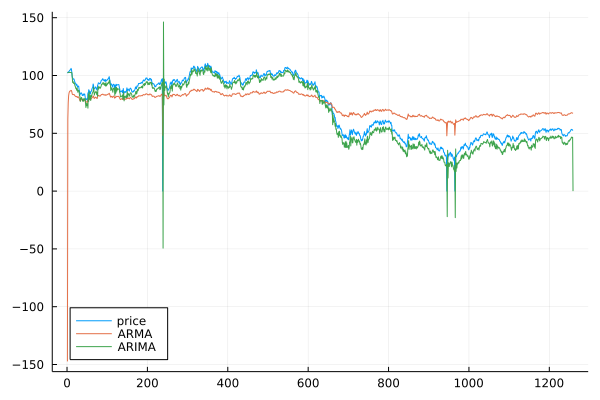

In [30]:
Oil = DataFrame(CSV.File("data/Oil.csv"))
r = r","
c = r"-"
amz=[]
for i in oil[:,6]
    i = replace(i,r => "")
    i = replace(i,c => "0")
    push!(amz,parse(Float64,i))
end
amz = reverse(amz)
predicted = zeros(1259)
predicted[1] = amz[1]
dPs = ARIMASolve(amz, 1256, 10, x -> 2/(exp(x)), 0)
for i in 1:length(dPs)
    predicted[i + 1] = predicted[i] + dPs[i]
end
errs = []
#farthest back is largest number, i.e. 0th index is end of range-1
for i in 1:1259
   pred = solver2(amz[1:i],0)
   pushfirst!(errs,pred)
end
plotArma = []
for i in 1:1259
   pred = fixedsolver(amz[1:i],0)
   pushfirst!(plotArma,pred-250)
end
plotArma = reverse(plotArma)
plot(1:1259,amz[1:1259],label="price")
plot!(1:1259,plotArma,label="ARMA")
plot!(1:1259,predicted,label="ARIMA",legend=:bottomleft)

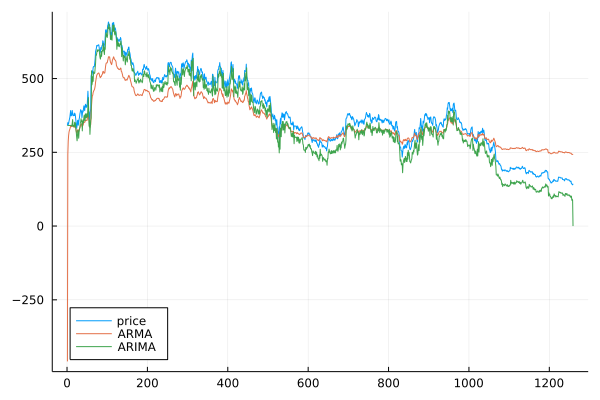

In [31]:
for i in net[:,6]
    push!(amz,i)
end
amz = reverse(amz)
predicted = zeros(1259)
predicted[1] = amz[1]
dPs = ARIMASolve(amz, 1256, 10, x -> 2/(exp(x)), 0)
for i in 1:length(dPs)
    predicted[i + 1] = predicted[i] + dPs[i]
end
errs = []
#farthest back is largest number, i.e. 0th index is end of range-1
for i in 1:1259
   pred = solver2(amz[1:i],0)
   pushfirst!(errs,pred)
end
plotArma = []
for i in 1:1259
   pred = fixedsolver(amz[1:i],0)
   pushfirst!(plotArma,pred-800)
end
plotArma = reverse(plotArma)
plot(1:1259,amz[1:1259],label="price")
plot!(1:1259,plotArma,label="ARMA")
plot!(1:1259,predicted,label="ARIMA",legend=:bottomleft)